## Identifying Potential Locations of Unmapped Sewer Inlets Using Deep Learning and Remote Sensing Data

## Import Libraries

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import rasterio
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

## Dataset

In [ ]:
from PIL import Image  
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

class DEMDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        valid_extensions = ['.tif', '.tiff']  # Defining valid extensions for raster images
        self.images = sorted([os.path.join(self.image_dir, f) for f in os.listdir(self.image_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])
        self.masks = sorted([os.path.join(self.mask_dir, f) for f in os.listdir(self.mask_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):        
        with rasterio.open(self.images[index]) as img_file:   # Load DEM and mask files as single-channel
            img = Image.fromarray(img_file.read(1))
        with rasterio.open(self.masks[index]) as mask_file:
            mask = Image.fromarray(mask_file.read(1))

        seed = np.random.randint(2147483647)            
        if self.transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            img = self.transform(img)            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transform(mask)
                  
        return img, mask

    def __len__(self):
        return len(self.images)


## Display Sample Images

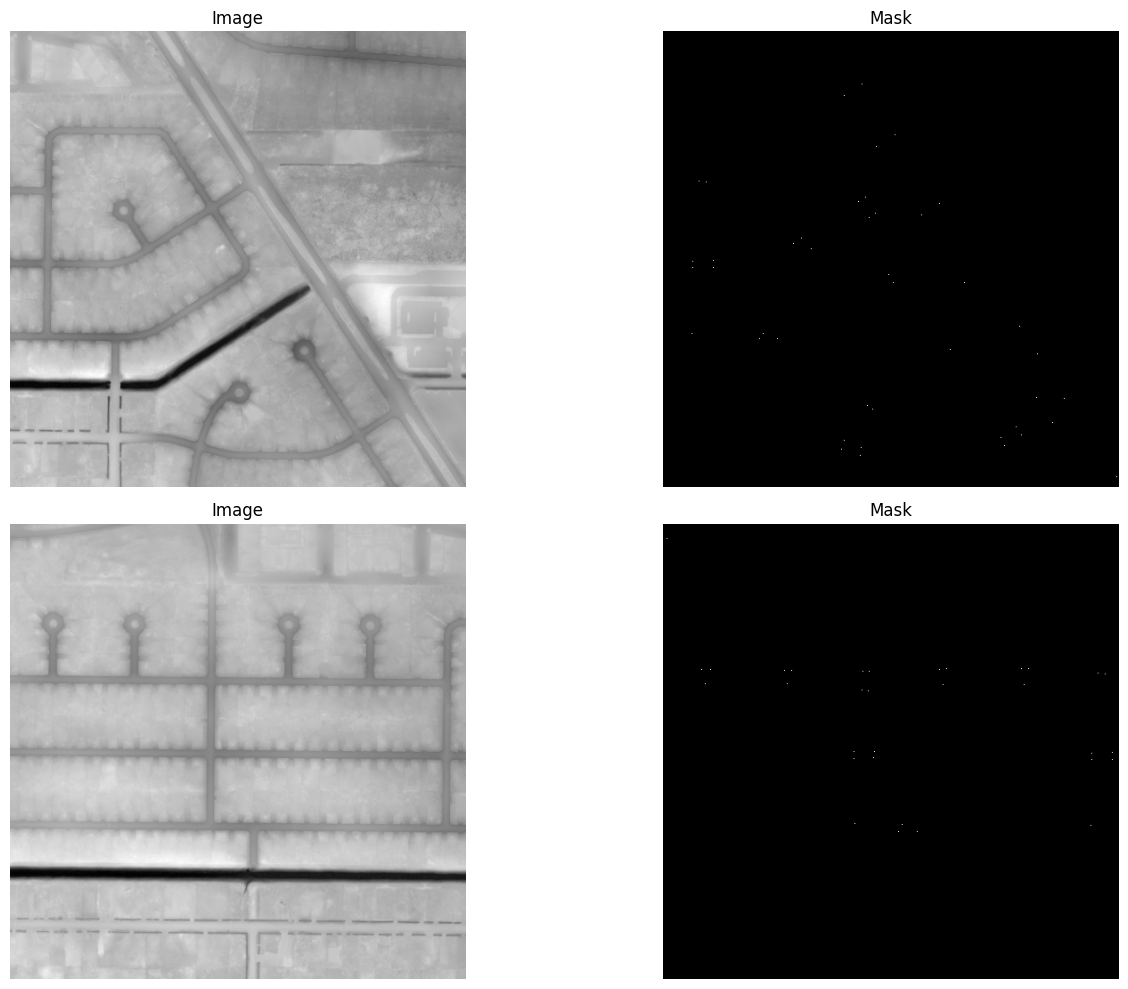

In [3]:
import rasterio
import matplotlib.pyplot as plt

def display_specific_samples(image_paths, mask_paths):
    if len(image_paths) != len(mask_paths):
        raise ValueError("The number of image paths must match the number of mask paths.")

    plt.figure(figsize=(15,10))
    
    for i in range(len(image_paths)):
        with rasterio.open(image_paths[i]) as img_file:
            img = img_file.read(1)
        with rasterio.open(mask_paths[i]) as mask_file:
            mask = mask_file.read(1)

        plt.subplot(len(image_paths), 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(len(image_paths), 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
specific_image_paths = [
    "C:/Users/alamsal/DL Project/clipped_rasters_train_data/A_004_072.tif",
    "C:/Users/alamsal/DL Project/clipped_rasters_train_data/A_004_071.tif"
]

specific_mask_paths = [
    "C:/Users/alamsal/DL Project/clipped_ground_truth_train_data/A_004_072.tif",
    "C:/Users/alamsal/DL Project/clipped_ground_truth_train_data/A_004_071.tif"
]

display_specific_samples(specific_image_paths, specific_mask_paths)


## Display Tranformed Images

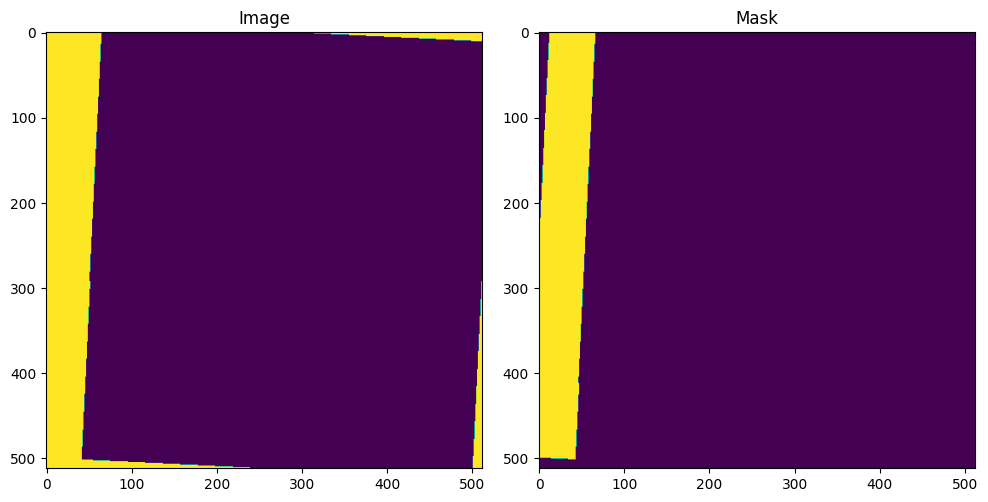

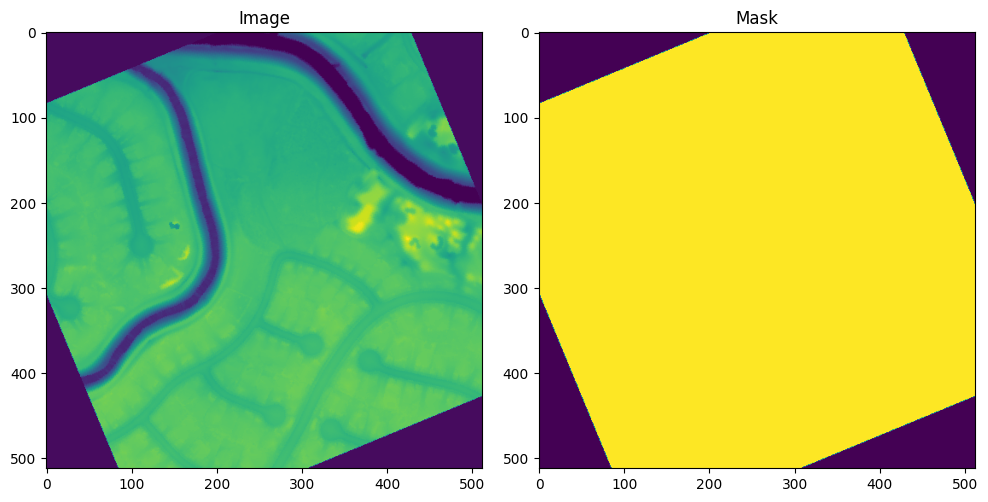

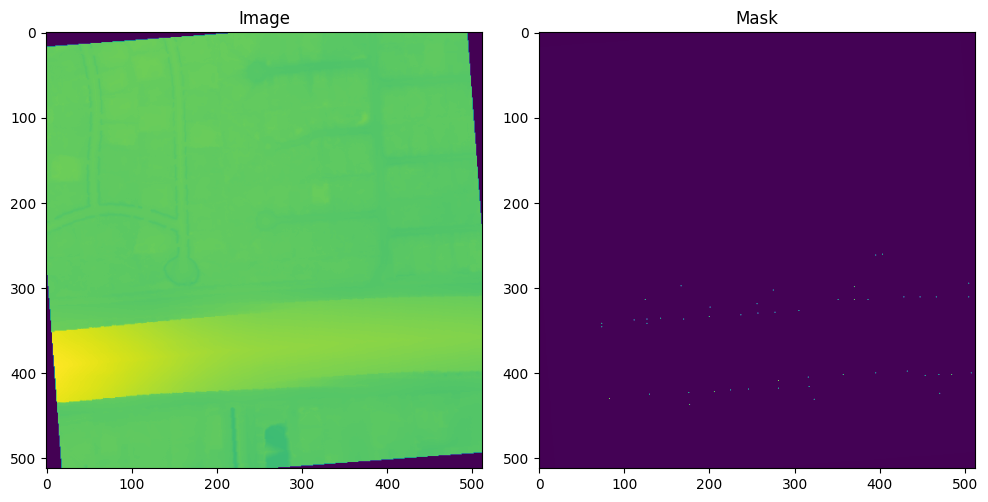

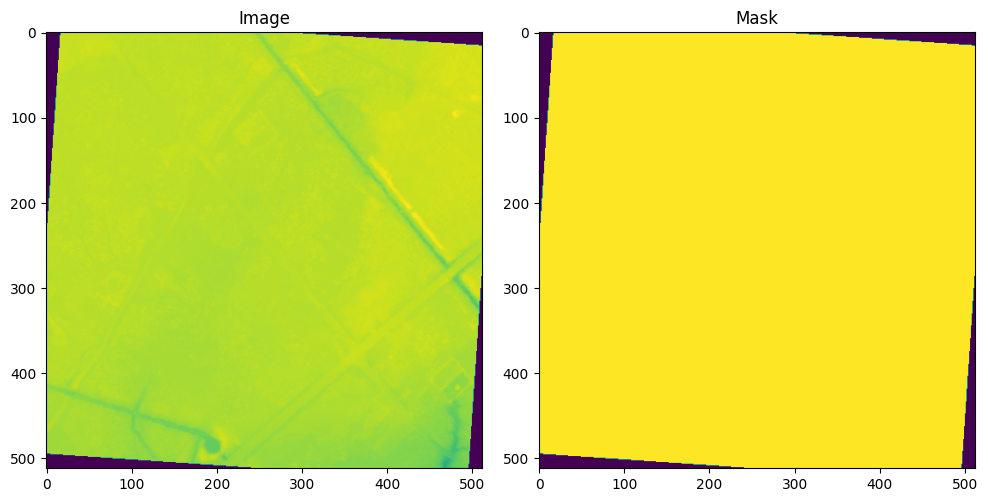

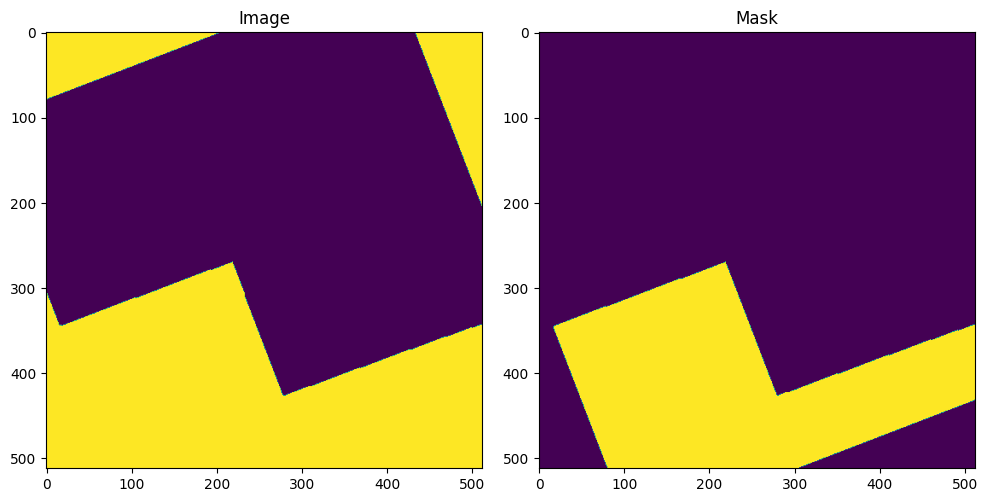

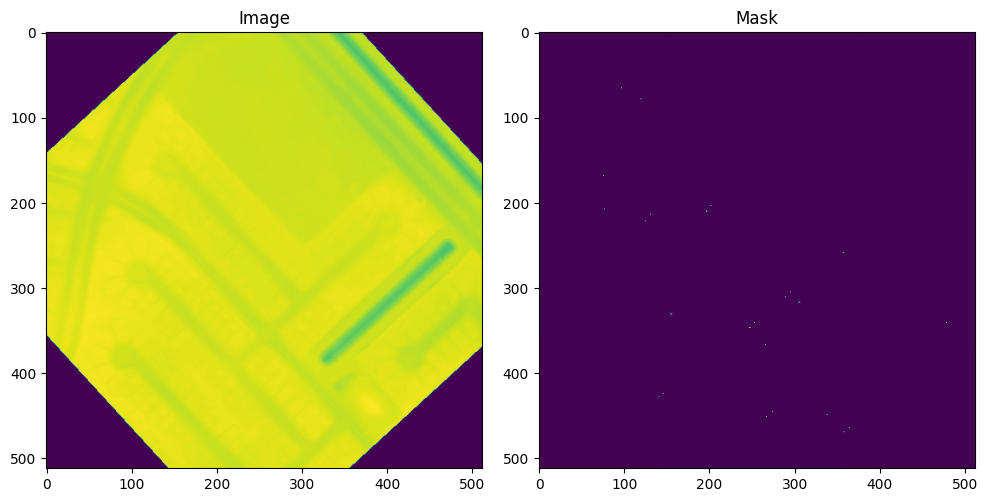

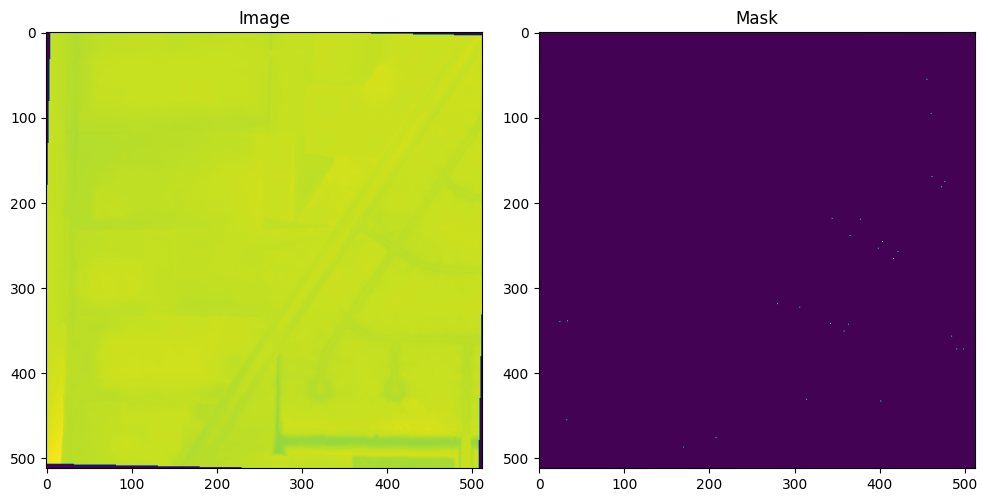

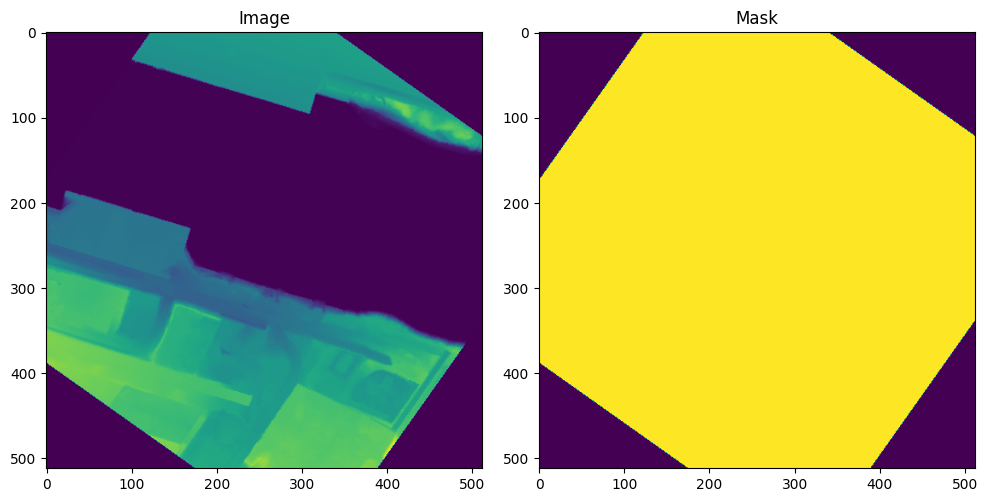

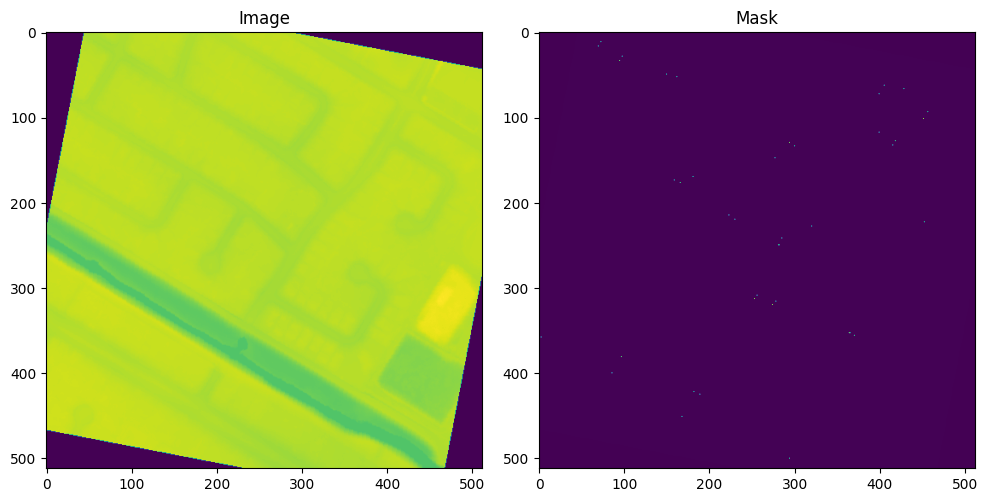

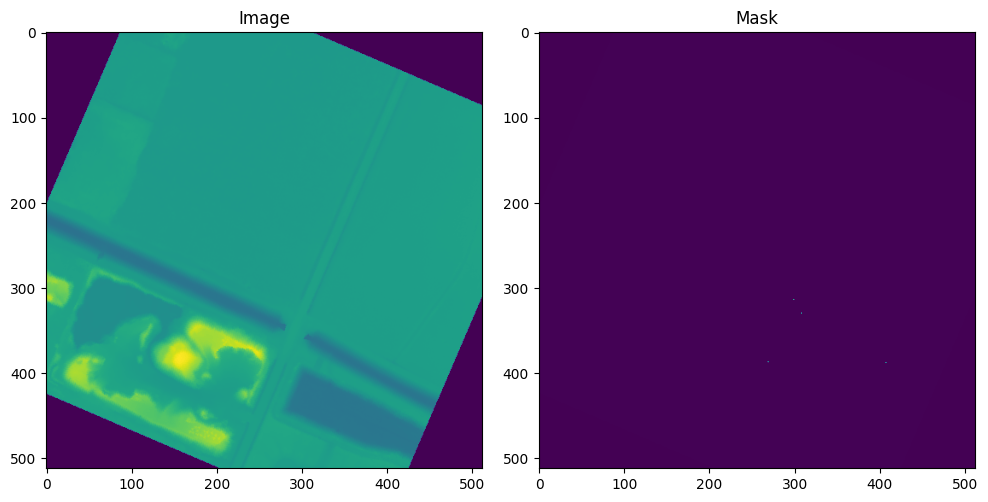

In [4]:
import os
import matplotlib.pyplot as plt

def visualize_transformed_images(dataset, num_samples):

    os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
    
    for i in range(num_samples):
        sample = dataset[i]  
        image = sample[0]  
        mask = sample[1]          
      
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
        axs[0].imshow(image[0, :, :])
        axs[0].set_title("Image")
        
        axs[1].imshow(mask[0, :, :])
        axs[1].set_title("Mask")
        
        plt.tight_layout()
        plt.show()

IMAGE_DIR = "C:/Users/alamsal/DL Project/clipped_rasters_train_data"
MASK_DIR = "C:/Users/alamsal/DL Project/clipped_ground_truth_train_data"

train_dataset = DEMDataset(IMAGE_DIR, MASK_DIR)
train_dataset, val_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))])

visualize_transformed_images(train_dataset, num_samples=10)


## UNet Model

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))
        
        # Decoder
        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        return self.out_conv(dec1)



## Training and Validation

Training Epoch 1/100: 100%|██████████| 1421/1421 [13:40<00:00,  1.73it/s]


Epoch 1/100, Train Loss: 167.797194, IoU: 0.000038, Dice: 0.000075, Precision: 0.000041, Recall: 0.000575


Validation: 100%|██████████| 356/356 [01:28<00:00,  4.01it/s]


Epoch 1/100, Val Loss: 162.572784, Val IoU: 0.000025, Val Dice: 0.000049, Val Precision: 0.000027, Val Recall: 0.000389


Training Epoch 2/100: 100%|██████████| 1421/1421 [13:28<00:00,  1.76it/s]


Epoch 2/100, Train Loss: 161.574632, IoU: 0.000051, Dice: 0.000102, Precision: 0.000056, Recall: 0.000814


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.40it/s]


Epoch 2/100, Val Loss: 161.771704, Val IoU: 0.000047, Val Dice: 0.000094, Val Precision: 0.000051, Val Recall: 0.000776


Training Epoch 3/100: 100%|██████████| 1421/1421 [13:24<00:00,  1.77it/s]


Epoch 3/100, Train Loss: 160.224641, IoU: 0.000063, Dice: 0.000126, Precision: 0.000068, Recall: 0.001104


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.40it/s]


Epoch 3/100, Val Loss: 159.485351, Val IoU: 0.000057, Val Dice: 0.000114, Val Precision: 0.000062, Val Recall: 0.001028


Training Epoch 4/100: 100%|██████████| 1421/1421 [13:31<00:00,  1.75it/s]


Epoch 4/100, Train Loss: 159.428627, IoU: 0.000068, Dice: 0.000136, Precision: 0.000074, Recall: 0.001030


Validation: 100%|██████████| 356/356 [01:25<00:00,  4.18it/s]


Epoch 4/100, Val Loss: 157.699989, Val IoU: 0.000076, Val Dice: 0.000151, Val Precision: 0.000083, Val Recall: 0.000963


Training Epoch 5/100: 100%|██████████| 1421/1421 [13:24<00:00,  1.77it/s]


Epoch 5/100, Train Loss: 158.923468, IoU: 0.000062, Dice: 0.000123, Precision: 0.000067, Recall: 0.000914


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 5/100, Val Loss: 157.992299, Val IoU: 0.000074, Val Dice: 0.000148, Val Precision: 0.000080, Val Recall: 0.001313


Training Epoch 6/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.79it/s]


Epoch 6/100, Train Loss: 158.794543, IoU: 0.000062, Dice: 0.000124, Precision: 0.000068, Recall: 0.001060


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 6/100, Val Loss: 157.652711, Val IoU: 0.000066, Val Dice: 0.000132, Val Precision: 0.000072, Val Recall: 0.000970


Training Epoch 7/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 7/100, Train Loss: 158.821807, IoU: 0.000050, Dice: 0.000100, Precision: 0.000054, Recall: 0.000790


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 7/100, Val Loss: 158.513644, Val IoU: 0.000092, Val Dice: 0.000184, Val Precision: 0.000102, Val Recall: 0.001296


Training Epoch 8/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 8/100, Train Loss: 158.557704, IoU: 0.000070, Dice: 0.000140, Precision: 0.000076, Recall: 0.001448


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 8/100, Val Loss: 157.746583, Val IoU: 0.000054, Val Dice: 0.000107, Val Precision: 0.000059, Val Recall: 0.000673


Training Epoch 9/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 9/100, Train Loss: 158.750499, IoU: 0.000065, Dice: 0.000130, Precision: 0.000071, Recall: 0.001028


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.43it/s]


Epoch 9/100, Val Loss: 157.525578, Val IoU: 0.000069, Val Dice: 0.000138, Val Precision: 0.000075, Val Recall: 0.001060


Training Epoch 10/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.79it/s]


Epoch 10/100, Train Loss: 158.712564, IoU: 0.000065, Dice: 0.000129, Precision: 0.000070, Recall: 0.001151


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 10/100, Val Loss: 157.374871, Val IoU: 0.000058, Val Dice: 0.000117, Val Precision: 0.000064, Val Recall: 0.000749


Training Epoch 11/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 11/100, Train Loss: 158.660330, IoU: 0.000057, Dice: 0.000115, Precision: 0.000062, Recall: 0.000828


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.43it/s]


Epoch 11/100, Val Loss: 157.556471, Val IoU: 0.000060, Val Dice: 0.000120, Val Precision: 0.000064, Val Recall: 0.001187


Training Epoch 12/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 12/100, Train Loss: 158.773814, IoU: 0.000058, Dice: 0.000117, Precision: 0.000064, Recall: 0.000897


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 12/100, Val Loss: 156.974344, Val IoU: 0.000052, Val Dice: 0.000104, Val Precision: 0.000056, Val Recall: 0.000777


Training Epoch 13/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 13/100, Train Loss: 158.603684, IoU: 0.000065, Dice: 0.000130, Precision: 0.000070, Recall: 0.001220


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 13/100, Val Loss: 157.350543, Val IoU: 0.000047, Val Dice: 0.000093, Val Precision: 0.000051, Val Recall: 0.000747


Training Epoch 14/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 14/100, Train Loss: 158.364450, IoU: 0.000064, Dice: 0.000127, Precision: 0.000069, Recall: 0.001067


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 14/100, Val Loss: 158.155529, Val IoU: 0.000096, Val Dice: 0.000192, Val Precision: 0.000104, Val Recall: 0.001547


Training Epoch 15/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.78it/s]


Epoch 15/100, Train Loss: 158.499060, IoU: 0.000082, Dice: 0.000164, Precision: 0.000089, Recall: 0.001411


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.43it/s]


Epoch 15/100, Val Loss: 157.393355, Val IoU: 0.000052, Val Dice: 0.000103, Val Precision: 0.000056, Val Recall: 0.000694


Training Epoch 16/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 16/100, Train Loss: 158.550765, IoU: 0.000064, Dice: 0.000128, Precision: 0.000069, Recall: 0.001048


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 16/100, Val Loss: 156.954900, Val IoU: 0.000059, Val Dice: 0.000117, Val Precision: 0.000064, Val Recall: 0.000784


Training Epoch 17/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 17/100, Train Loss: 158.328164, IoU: 0.000071, Dice: 0.000143, Precision: 0.000078, Recall: 0.001049


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 17/100, Val Loss: 157.694828, Val IoU: 0.000050, Val Dice: 0.000100, Val Precision: 0.000054, Val Recall: 0.000840


Training Epoch 18/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 18/100, Train Loss: 158.623510, IoU: 0.000090, Dice: 0.000179, Precision: 0.000097, Recall: 0.001426


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 18/100, Val Loss: 157.958237, Val IoU: 0.000047, Val Dice: 0.000094, Val Precision: 0.000051, Val Recall: 0.000839


Training Epoch 19/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 19/100, Train Loss: 158.434057, IoU: 0.000058, Dice: 0.000117, Precision: 0.000064, Recall: 0.000939


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 19/100, Val Loss: 156.944811, Val IoU: 0.000072, Val Dice: 0.000144, Val Precision: 0.000078, Val Recall: 0.001196


Training Epoch 20/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.78it/s]


Epoch 20/100, Train Loss: 158.443003, IoU: 0.000082, Dice: 0.000165, Precision: 0.000089, Recall: 0.001361


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 20/100, Val Loss: 157.245988, Val IoU: 0.000076, Val Dice: 0.000153, Val Precision: 0.000083, Val Recall: 0.001241


Training Epoch 21/100: 100%|██████████| 1421/1421 [13:14<00:00,  1.79it/s]


Epoch 21/100, Train Loss: 158.359220, IoU: 0.000083, Dice: 0.000165, Precision: 0.000090, Recall: 0.001315


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 21/100, Val Loss: 157.838179, Val IoU: 0.000061, Val Dice: 0.000121, Val Precision: 0.000067, Val Recall: 0.000880


Training Epoch 22/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 22/100, Train Loss: 158.069480, IoU: 0.000089, Dice: 0.000178, Precision: 0.000097, Recall: 0.001473


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 22/100, Val Loss: 157.339684, Val IoU: 0.000069, Val Dice: 0.000137, Val Precision: 0.000075, Val Recall: 0.000933


Training Epoch 23/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 23/100, Train Loss: 158.352493, IoU: 0.000067, Dice: 0.000134, Precision: 0.000073, Recall: 0.000997


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 23/100, Val Loss: 157.413437, Val IoU: 0.000069, Val Dice: 0.000138, Val Precision: 0.000075, Val Recall: 0.001327


Training Epoch 24/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 24/100, Train Loss: 158.488358, IoU: 0.000071, Dice: 0.000143, Precision: 0.000078, Recall: 0.001035


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 24/100, Val Loss: 157.620352, Val IoU: 0.000062, Val Dice: 0.000123, Val Precision: 0.000067, Val Recall: 0.000973


Training Epoch 25/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 25/100, Train Loss: 158.351188, IoU: 0.000088, Dice: 0.000175, Precision: 0.000095, Recall: 0.001586


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 25/100, Val Loss: 157.263605, Val IoU: 0.000058, Val Dice: 0.000116, Val Precision: 0.000064, Val Recall: 0.000681


Training Epoch 26/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 26/100, Train Loss: 158.236175, IoU: 0.000085, Dice: 0.000170, Precision: 0.000093, Recall: 0.001469


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 26/100, Val Loss: 157.226793, Val IoU: 0.000062, Val Dice: 0.000123, Val Precision: 0.000067, Val Recall: 0.000839


Training Epoch 27/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 27/100, Train Loss: 158.239655, IoU: 0.000098, Dice: 0.000196, Precision: 0.000107, Recall: 0.001424


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 27/100, Val Loss: 157.664004, Val IoU: 0.000059, Val Dice: 0.000117, Val Precision: 0.000064, Val Recall: 0.000814


Training Epoch 28/100: 100%|██████████| 1421/1421 [13:14<00:00,  1.79it/s]


Epoch 28/100, Train Loss: 158.096701, IoU: 0.000091, Dice: 0.000181, Precision: 0.000099, Recall: 0.001417


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 28/100, Val Loss: 157.460953, Val IoU: 0.000079, Val Dice: 0.000158, Val Precision: 0.000086, Val Recall: 0.001203


Training Epoch 29/100: 100%|██████████| 1421/1421 [13:14<00:00,  1.79it/s]


Epoch 29/100, Train Loss: 158.152482, IoU: 0.000083, Dice: 0.000166, Precision: 0.000091, Recall: 0.001240


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 29/100, Val Loss: 157.350918, Val IoU: 0.000059, Val Dice: 0.000117, Val Precision: 0.000064, Val Recall: 0.000929


Training Epoch 30/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 30/100, Train Loss: 158.302022, IoU: 0.000088, Dice: 0.000176, Precision: 0.000096, Recall: 0.001808


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 30/100, Val Loss: 157.410846, Val IoU: 0.000047, Val Dice: 0.000093, Val Precision: 0.000051, Val Recall: 0.000745


Training Epoch 31/100: 100%|██████████| 1421/1421 [13:14<00:00,  1.79it/s]


Epoch 31/100, Train Loss: 158.365451, IoU: 0.000099, Dice: 0.000198, Precision: 0.000109, Recall: 0.001650


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 31/100, Val Loss: 157.172043, Val IoU: 0.000098, Val Dice: 0.000197, Val Precision: 0.000107, Val Recall: 0.001934


Training Epoch 32/100: 100%|██████████| 1421/1421 [13:21<00:00,  1.77it/s]


Epoch 32/100, Train Loss: 158.217009, IoU: 0.000093, Dice: 0.000186, Precision: 0.000101, Recall: 0.001737


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.40it/s]


Epoch 32/100, Val Loss: 157.309623, Val IoU: 0.000084, Val Dice: 0.000168, Val Precision: 0.000091, Val Recall: 0.001304


Training Epoch 33/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.78it/s]


Epoch 33/100, Train Loss: 158.314333, IoU: 0.000081, Dice: 0.000162, Precision: 0.000089, Recall: 0.001491


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 33/100, Val Loss: 157.607324, Val IoU: 0.000119, Val Dice: 0.000237, Val Precision: 0.000131, Val Recall: 0.001558


Training Epoch 34/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.79it/s]


Epoch 34/100, Train Loss: 158.249365, IoU: 0.000088, Dice: 0.000176, Precision: 0.000096, Recall: 0.001407


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 34/100, Val Loss: 157.164742, Val IoU: 0.000099, Val Dice: 0.000198, Val Precision: 0.000107, Val Recall: 0.002357


Training Epoch 35/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 35/100, Train Loss: 158.071762, IoU: 0.000112, Dice: 0.000224, Precision: 0.000122, Recall: 0.001714


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 35/100, Val Loss: 157.273852, Val IoU: 0.000103, Val Dice: 0.000205, Val Precision: 0.000110, Val Recall: 0.002399


Training Epoch 36/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 36/100, Train Loss: 158.211453, IoU: 0.000119, Dice: 0.000238, Precision: 0.000130, Recall: 0.001762


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 36/100, Val Loss: 157.586715, Val IoU: 0.000141, Val Dice: 0.000282, Val Precision: 0.000153, Val Recall: 0.002560


Training Epoch 37/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.78it/s]


Epoch 37/100, Train Loss: 158.124626, IoU: 0.000149, Dice: 0.000299, Precision: 0.000163, Recall: 0.002402


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 37/100, Val Loss: 157.243702, Val IoU: 0.000158, Val Dice: 0.000315, Val Precision: 0.000171, Val Recall: 0.002353


Training Epoch 38/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 38/100, Train Loss: 158.339272, IoU: 0.000195, Dice: 0.000388, Precision: 0.000211, Recall: 0.003252


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 38/100, Val Loss: 157.234895, Val IoU: 0.000132, Val Dice: 0.000263, Val Precision: 0.000145, Val Recall: 0.001878


Training Epoch 39/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 39/100, Train Loss: 158.343455, IoU: 0.000190, Dice: 0.000380, Precision: 0.000207, Recall: 0.003198


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 39/100, Val Loss: 157.472887, Val IoU: 0.000057, Val Dice: 0.000113, Val Precision: 0.000062, Val Recall: 0.000801


Training Epoch 40/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 40/100, Train Loss: 157.982709, IoU: 0.000201, Dice: 0.000401, Precision: 0.000219, Recall: 0.003100


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 40/100, Val Loss: 157.546989, Val IoU: 0.000142, Val Dice: 0.000283, Val Precision: 0.000155, Val Recall: 0.001956


Training Epoch 41/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.79it/s]


Epoch 41/100, Train Loss: 158.260647, IoU: 0.000257, Dice: 0.000513, Precision: 0.000278, Recall: 0.004026


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 41/100, Val Loss: 157.379107, Val IoU: 0.000238, Val Dice: 0.000475, Val Precision: 0.000257, Val Recall: 0.003682


Training Epoch 42/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.79it/s]


Epoch 42/100, Train Loss: 158.313635, IoU: 0.000264, Dice: 0.000528, Precision: 0.000286, Recall: 0.004490


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 42/100, Val Loss: 157.317804, Val IoU: 0.000216, Val Dice: 0.000432, Val Precision: 0.000236, Val Recall: 0.003453


Training Epoch 43/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 43/100, Train Loss: 158.100362, IoU: 0.000315, Dice: 0.000630, Precision: 0.000342, Recall: 0.004808


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 43/100, Val Loss: 157.628010, Val IoU: 0.000161, Val Dice: 0.000321, Val Precision: 0.000177, Val Recall: 0.002288


Training Epoch 44/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 44/100, Train Loss: 158.148524, IoU: 0.000344, Dice: 0.000688, Precision: 0.000372, Recall: 0.005698


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 44/100, Val Loss: 157.481325, Val IoU: 0.000511, Val Dice: 0.001020, Val Precision: 0.000554, Val Recall: 0.008229


Training Epoch 45/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.79it/s]


Epoch 45/100, Train Loss: 158.257561, IoU: 0.000416, Dice: 0.000831, Precision: 0.000450, Recall: 0.006955


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 45/100, Val Loss: 157.657685, Val IoU: 0.000484, Val Dice: 0.000965, Val Precision: 0.000522, Val Recall: 0.007574


Training Epoch 46/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 46/100, Train Loss: 158.045759, IoU: 0.000345, Dice: 0.000689, Precision: 0.000374, Recall: 0.005421


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 46/100, Val Loss: 156.780905, Val IoU: 0.000325, Val Dice: 0.000648, Val Precision: 0.000351, Val Recall: 0.005475


Training Epoch 47/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 47/100, Train Loss: 158.476572, IoU: 0.000433, Dice: 0.000864, Precision: 0.000467, Recall: 0.007626


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.43it/s]


Epoch 47/100, Val Loss: 157.154836, Val IoU: 0.000527, Val Dice: 0.001052, Val Precision: 0.000570, Val Recall: 0.008268


Training Epoch 48/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 48/100, Train Loss: 158.116169, IoU: 0.000507, Dice: 0.001012, Precision: 0.000547, Recall: 0.008717


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 48/100, Val Loss: 157.080343, Val IoU: 0.000598, Val Dice: 0.001193, Val Precision: 0.000648, Val Recall: 0.009501


Training Epoch 49/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 49/100, Train Loss: 158.104693, IoU: 0.000470, Dice: 0.000937, Precision: 0.000507, Recall: 0.007902


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 49/100, Val Loss: 156.725230, Val IoU: 0.000473, Val Dice: 0.000944, Val Precision: 0.000511, Val Recall: 0.007839


Training Epoch 50/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 50/100, Train Loss: 158.140233, IoU: 0.000579, Dice: 0.001155, Precision: 0.000623, Recall: 0.009628


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 50/100, Val Loss: 157.234808, Val IoU: 0.000621, Val Dice: 0.001238, Val Precision: 0.000667, Val Recall: 0.011023


Training Epoch 51/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 51/100, Train Loss: 158.359793, IoU: 0.000606, Dice: 0.001209, Precision: 0.000655, Recall: 0.010914


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 51/100, Val Loss: 157.235840, Val IoU: 0.000677, Val Dice: 0.001352, Val Precision: 0.000728, Val Recall: 0.011970


Training Epoch 52/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 52/100, Train Loss: 158.047185, IoU: 0.000585, Dice: 0.001168, Precision: 0.000632, Recall: 0.010251


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 52/100, Val Loss: 157.428419, Val IoU: 0.000552, Val Dice: 0.001102, Val Precision: 0.000594, Val Recall: 0.010125


Training Epoch 53/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.78it/s]


Epoch 53/100, Train Loss: 158.062489, IoU: 0.000633, Dice: 0.001264, Precision: 0.000684, Recall: 0.010801


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 53/100, Val Loss: 157.239656, Val IoU: 0.000705, Val Dice: 0.001407, Val Precision: 0.000760, Val Recall: 0.012074


Training Epoch 54/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 54/100, Train Loss: 158.253577, IoU: 0.000759, Dice: 0.001513, Precision: 0.000819, Recall: 0.012536


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 54/100, Val Loss: 157.582163, Val IoU: 0.000784, Val Dice: 0.001564, Val Precision: 0.000846, Val Recall: 0.013104


Training Epoch 55/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 55/100, Train Loss: 158.178432, IoU: 0.000713, Dice: 0.001423, Precision: 0.000769, Recall: 0.012148


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 55/100, Val Loss: 157.328742, Val IoU: 0.000817, Val Dice: 0.001629, Val Precision: 0.000881, Val Recall: 0.013790


Training Epoch 56/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 56/100, Train Loss: 158.268641, IoU: 0.000835, Dice: 0.001665, Precision: 0.000899, Recall: 0.015334


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 56/100, Val Loss: 156.995617, Val IoU: 0.000821, Val Dice: 0.001639, Val Precision: 0.000886, Val Recall: 0.013963


Training Epoch 57/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 57/100, Train Loss: 158.231239, IoU: 0.000806, Dice: 0.001609, Precision: 0.000869, Recall: 0.014748


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 57/100, Val Loss: 157.613900, Val IoU: 0.000937, Val Dice: 0.001869, Val Precision: 0.001012, Val Recall: 0.017016


Training Epoch 58/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 58/100, Train Loss: 158.351505, IoU: 0.000860, Dice: 0.001716, Precision: 0.000927, Recall: 0.014823


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 58/100, Val Loss: 157.475631, Val IoU: 0.001039, Val Dice: 0.002072, Val Precision: 0.001119, Val Recall: 0.018490


Training Epoch 59/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 59/100, Train Loss: 158.177384, IoU: 0.000970, Dice: 0.001935, Precision: 0.001046, Recall: 0.016167


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 59/100, Val Loss: 157.326136, Val IoU: 0.001102, Val Dice: 0.002197, Val Precision: 0.001186, Val Recall: 0.021355


Training Epoch 60/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 60/100, Train Loss: 158.024529, IoU: 0.000997, Dice: 0.001989, Precision: 0.001072, Recall: 0.017830


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 60/100, Val Loss: 157.532013, Val IoU: 0.001241, Val Dice: 0.002476, Val Precision: 0.001334, Val Recall: 0.023722


Training Epoch 61/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 61/100, Train Loss: 158.152377, IoU: 0.000647, Dice: 0.001290, Precision: 0.000696, Recall: 0.011672


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 61/100, Val Loss: 157.282312, Val IoU: 0.000145, Val Dice: 0.000289, Val Precision: 0.000158, Val Recall: 0.002309


Training Epoch 62/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 62/100, Train Loss: 158.095296, IoU: 0.000375, Dice: 0.000748, Precision: 0.000406, Recall: 0.006008


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 62/100, Val Loss: 157.657444, Val IoU: 0.001120, Val Dice: 0.002235, Val Precision: 0.001210, Val Recall: 0.020148


Training Epoch 63/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 63/100, Train Loss: 157.995106, IoU: 0.001086, Dice: 0.002166, Precision: 0.001170, Recall: 0.018915


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 63/100, Val Loss: 157.268878, Val IoU: 0.001067, Val Dice: 0.002129, Val Precision: 0.001149, Val Recall: 0.019923


Training Epoch 64/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.78it/s]


Epoch 64/100, Train Loss: 158.394285, IoU: 0.001023, Dice: 0.002040, Precision: 0.001102, Recall: 0.017275


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.44it/s]


Epoch 64/100, Val Loss: 157.122108, Val IoU: 0.001217, Val Dice: 0.002427, Val Precision: 0.001307, Val Recall: 0.022784


Training Epoch 65/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 65/100, Train Loss: 158.148754, IoU: 0.001286, Dice: 0.002564, Precision: 0.001383, Recall: 0.022857


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 65/100, Val Loss: 157.528505, Val IoU: 0.001098, Val Dice: 0.002189, Val Precision: 0.001181, Val Recall: 0.020072


Training Epoch 66/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 66/100, Train Loss: 158.146157, IoU: 0.001426, Dice: 0.002843, Precision: 0.001533, Recall: 0.026245


Validation: 100%|██████████| 356/356 [01:20<00:00,  4.45it/s]


Epoch 66/100, Val Loss: 156.875669, Val IoU: 0.001484, Val Dice: 0.002960, Val Precision: 0.001599, Val Recall: 0.025277


Training Epoch 67/100: 100%|██████████| 1421/1421 [13:16<00:00,  1.78it/s]


Epoch 67/100, Train Loss: 157.932078, IoU: 0.001473, Dice: 0.002936, Precision: 0.001583, Recall: 0.026268


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 67/100, Val Loss: 157.398939, Val IoU: 0.001857, Val Dice: 0.003701, Val Precision: 0.001992, Val Recall: 0.034075


Training Epoch 68/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 68/100, Train Loss: 158.321869, IoU: 0.001612, Dice: 0.003213, Precision: 0.001734, Recall: 0.028859


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 68/100, Val Loss: 157.422050, Val IoU: 0.001890, Val Dice: 0.003767, Val Precision: 0.002024, Val Recall: 0.034261


Training Epoch 69/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 69/100, Train Loss: 158.069360, IoU: 0.001832, Dice: 0.003650, Precision: 0.001972, Recall: 0.031629


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 69/100, Val Loss: 157.338338, Val IoU: 0.002355, Val Dice: 0.004691, Val Precision: 0.002525, Val Recall: 0.042754


Training Epoch 70/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 70/100, Train Loss: 158.201444, IoU: 0.002183, Dice: 0.004345, Precision: 0.002352, Recall: 0.036153


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 70/100, Val Loss: 157.453592, Val IoU: 0.003126, Val Dice: 0.006218, Val Precision: 0.003366, Val Recall: 0.051031


Training Epoch 71/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 71/100, Train Loss: 158.161601, IoU: 0.002993, Dice: 0.005955, Precision: 0.003221, Recall: 0.050715


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 71/100, Val Loss: 157.152265, Val IoU: 0.003734, Val Dice: 0.007425, Val Precision: 0.004017, Val Recall: 0.063791


Training Epoch 72/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 72/100, Train Loss: 158.131961, IoU: 0.003303, Dice: 0.006569, Precision: 0.003559, Recall: 0.054137


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 72/100, Val Loss: 157.230307, Val IoU: 0.003094, Val Dice: 0.006156, Val Precision: 0.003326, Val Recall: 0.051682


Training Epoch 73/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 73/100, Train Loss: 157.981468, IoU: 0.003071, Dice: 0.006109, Precision: 0.003302, Recall: 0.052215


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 73/100, Val Loss: 157.239802, Val IoU: 0.004018, Val Dice: 0.007988, Val Precision: 0.004317, Val Recall: 0.069059


Training Epoch 74/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 74/100, Train Loss: 158.234514, IoU: 0.003762, Dice: 0.007479, Precision: 0.004047, Recall: 0.063665


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 74/100, Val Loss: 157.066001, Val IoU: 0.004325, Val Dice: 0.008595, Val Precision: 0.004641, Val Recall: 0.076298


Training Epoch 75/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 75/100, Train Loss: 158.085779, IoU: 0.003581, Dice: 0.007116, Precision: 0.003853, Recall: 0.059846


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 75/100, Val Loss: 157.266951, Val IoU: 0.004447, Val Dice: 0.008833, Val Precision: 0.004783, Val Recall: 0.073573


Training Epoch 76/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 76/100, Train Loss: 158.092333, IoU: 0.003992, Dice: 0.007933, Precision: 0.004291, Recall: 0.067205


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 76/100, Val Loss: 157.087112, Val IoU: 0.004145, Val Dice: 0.008237, Val Precision: 0.004448, Val Recall: 0.072841


Training Epoch 77/100: 100%|██████████| 1421/1421 [13:15<00:00,  1.79it/s]


Epoch 77/100, Train Loss: 157.861092, IoU: 0.004215, Dice: 0.008375, Precision: 0.004534, Recall: 0.069762


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 77/100, Val Loss: 157.194022, Val IoU: 0.004654, Val Dice: 0.009245, Val Precision: 0.004989, Val Recall: 0.082087


Training Epoch 78/100: 100%|██████████| 1421/1421 [13:18<00:00,  1.78it/s]


Epoch 78/100, Train Loss: 158.098345, IoU: 0.004579, Dice: 0.009095, Precision: 0.004926, Recall: 0.074710


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.45it/s]


Epoch 78/100, Val Loss: 157.137079, Val IoU: 0.004968, Val Dice: 0.009863, Val Precision: 0.005340, Val Recall: 0.082605


Training Epoch 79/100: 100%|██████████| 1421/1421 [13:20<00:00,  1.78it/s]


Epoch 79/100, Train Loss: 158.009831, IoU: 0.004769, Dice: 0.009471, Precision: 0.005121, Recall: 0.079646


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.38it/s]


Epoch 79/100, Val Loss: 157.510244, Val IoU: 0.004764, Val Dice: 0.009458, Val Precision: 0.005125, Val Recall: 0.083850


Training Epoch 80/100: 100%|██████████| 1421/1421 [13:29<00:00,  1.76it/s]


Epoch 80/100, Train Loss: 158.054059, IoU: 0.005026, Dice: 0.009975, Precision: 0.005405, Recall: 0.081642


Validation: 100%|██████████| 356/356 [01:25<00:00,  4.15it/s]


Epoch 80/100, Val Loss: 157.167955, Val IoU: 0.005300, Val Dice: 0.010519, Val Precision: 0.005690, Val Recall: 0.086744


Training Epoch 81/100: 100%|██████████| 1421/1421 [13:24<00:00,  1.77it/s]


Epoch 81/100, Train Loss: 157.867445, IoU: 0.005373, Dice: 0.010661, Precision: 0.005766, Recall: 0.090620


Validation: 100%|██████████| 356/356 [01:24<00:00,  4.21it/s]


Epoch 81/100, Val Loss: 157.601954, Val IoU: 0.006078, Val Dice: 0.012051, Val Precision: 0.006512, Val Recall: 0.103283


Training Epoch 82/100: 100%|██████████| 1421/1421 [13:23<00:00,  1.77it/s]


Epoch 82/100, Train Loss: 158.375882, IoU: 0.005564, Dice: 0.011038, Precision: 0.005971, Recall: 0.093547


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.36it/s]


Epoch 82/100, Val Loss: 157.552546, Val IoU: 0.005846, Val Dice: 0.011596, Val Precision: 0.006279, Val Recall: 0.094819


Training Epoch 83/100: 100%|██████████| 1421/1421 [13:33<00:00,  1.75it/s]


Epoch 83/100, Train Loss: 158.200851, IoU: 0.005942, Dice: 0.011783, Precision: 0.006382, Recall: 0.099299


Validation: 100%|██████████| 356/356 [01:26<00:00,  4.10it/s]


Epoch 83/100, Val Loss: 157.100736, Val IoU: 0.006167, Val Dice: 0.012226, Val Precision: 0.006609, Val Recall: 0.108364


Training Epoch 84/100: 100%|██████████| 1421/1421 [13:23<00:00,  1.77it/s]


Epoch 84/100, Train Loss: 158.128011, IoU: 0.006057, Dice: 0.012008, Precision: 0.006507, Recall: 0.098552


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.38it/s]


Epoch 84/100, Val Loss: 157.290620, Val IoU: 0.006396, Val Dice: 0.012678, Val Precision: 0.006863, Val Recall: 0.109202


Training Epoch 85/100: 100%|██████████| 1421/1421 [13:25<00:00,  1.76it/s]


Epoch 85/100, Train Loss: 158.201710, IoU: 0.006474, Dice: 0.012830, Precision: 0.006951, Recall: 0.106829


Validation: 100%|██████████| 356/356 [01:25<00:00,  4.17it/s]


Epoch 85/100, Val Loss: 156.778224, Val IoU: 0.006332, Val Dice: 0.012551, Val Precision: 0.006780, Val Recall: 0.112381


Training Epoch 86/100: 100%|██████████| 1421/1421 [13:40<00:00,  1.73it/s]


Epoch 86/100, Train Loss: 158.298382, IoU: 0.006633, Dice: 0.013141, Precision: 0.007116, Recall: 0.110460


Validation: 100%|██████████| 356/356 [01:27<00:00,  4.07it/s]


Epoch 86/100, Val Loss: 156.734015, Val IoU: 0.007066, Val Dice: 0.013994, Val Precision: 0.007565, Val Recall: 0.118689


Training Epoch 87/100: 100%|██████████| 1421/1421 [13:28<00:00,  1.76it/s]


Epoch 87/100, Train Loss: 157.910893, IoU: 0.006974, Dice: 0.013816, Precision: 0.007485, Recall: 0.117303


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 87/100, Val Loss: 157.143133, Val IoU: 0.007273, Val Dice: 0.014402, Val Precision: 0.007784, Val Recall: 0.125686


Training Epoch 88/100: 100%|██████████| 1421/1421 [13:27<00:00,  1.76it/s]


Epoch 88/100, Train Loss: 157.972747, IoU: 0.004639, Dice: 0.009187, Precision: 0.004973, Recall: 0.076037


Validation: 100%|██████████| 356/356 [01:25<00:00,  4.15it/s]


Epoch 88/100, Val Loss: 157.620657, Val IoU: 0.000341, Val Dice: 0.000682, Val Precision: 0.000372, Val Recall: 0.005665


Training Epoch 89/100: 100%|██████████| 1421/1421 [13:26<00:00,  1.76it/s]


Epoch 89/100, Train Loss: 158.175944, IoU: 0.004277, Dice: 0.008482, Precision: 0.004597, Recall: 0.070231


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 89/100, Val Loss: 156.958869, Val IoU: 0.006606, Val Dice: 0.013093, Val Precision: 0.007075, Val Recall: 0.113277


Training Epoch 90/100: 100%|██████████| 1421/1421 [13:21<00:00,  1.77it/s]


Epoch 90/100, Train Loss: 157.901595, IoU: 0.007232, Dice: 0.014318, Precision: 0.007756, Recall: 0.119116


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.37it/s]


Epoch 90/100, Val Loss: 157.321089, Val IoU: 0.007442, Val Dice: 0.014735, Val Precision: 0.007977, Val Recall: 0.128033


Training Epoch 91/100: 100%|██████████| 1421/1421 [13:25<00:00,  1.76it/s]


Epoch 91/100, Train Loss: 158.014538, IoU: 0.007213, Dice: 0.014279, Precision: 0.007732, Recall: 0.119095


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.39it/s]


Epoch 91/100, Val Loss: 157.416810, Val IoU: 0.006820, Val Dice: 0.013510, Val Precision: 0.007316, Val Recall: 0.113515


Training Epoch 92/100: 100%|██████████| 1421/1421 [13:25<00:00,  1.76it/s]


Epoch 92/100, Train Loss: 157.971929, IoU: 0.007593, Dice: 0.015029, Precision: 0.008135, Recall: 0.125390


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.39it/s]


Epoch 92/100, Val Loss: 156.674266, Val IoU: 0.007837, Val Dice: 0.015510, Val Precision: 0.008373, Val Recall: 0.135223


Training Epoch 93/100: 100%|██████████| 1421/1421 [13:24<00:00,  1.77it/s]


Epoch 93/100, Train Loss: 158.069562, IoU: 0.007690, Dice: 0.015217, Precision: 0.008247, Recall: 0.126938


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.39it/s]


Epoch 93/100, Val Loss: 157.125382, Val IoU: 0.007654, Val Dice: 0.015152, Val Precision: 0.008194, Val Recall: 0.130304


Training Epoch 94/100: 100%|██████████| 1421/1421 [13:22<00:00,  1.77it/s]


Epoch 94/100, Train Loss: 157.906933, IoU: 0.007957, Dice: 0.015741, Precision: 0.008519, Recall: 0.131975


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.39it/s]


Epoch 94/100, Val Loss: 156.926942, Val IoU: 0.008186, Val Dice: 0.016191, Val Precision: 0.008764, Val Recall: 0.144305


Training Epoch 95/100: 100%|██████████| 1421/1421 [13:27<00:00,  1.76it/s]


Epoch 95/100, Train Loss: 158.252389, IoU: 0.007925, Dice: 0.015677, Precision: 0.008481, Recall: 0.133338


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.46it/s]


Epoch 95/100, Val Loss: 157.409056, Val IoU: 0.000113, Val Dice: 0.000225, Val Precision: 0.000123, Val Recall: 0.001467


Training Epoch 96/100: 100%|██████████| 1421/1421 [13:12<00:00,  1.79it/s]


Epoch 96/100, Train Loss: 158.134827, IoU: 0.007949, Dice: 0.015722, Precision: 0.008508, Recall: 0.134510


Validation: 100%|██████████| 356/356 [01:19<00:00,  4.47it/s]


Epoch 96/100, Val Loss: 157.097589, Val IoU: 0.008772, Val Dice: 0.017346, Val Precision: 0.009378, Val Recall: 0.151009


Training Epoch 97/100: 100%|██████████| 1421/1421 [13:20<00:00,  1.78it/s]


Epoch 97/100, Train Loss: 157.931955, IoU: 0.008439, Dice: 0.016689, Precision: 0.009034, Recall: 0.141611


Validation: 100%|██████████| 356/356 [01:21<00:00,  4.38it/s]


Epoch 97/100, Val Loss: 156.893245, Val IoU: 0.008890, Val Dice: 0.017575, Val Precision: 0.009498, Val Recall: 0.154393


Training Epoch 98/100: 100%|██████████| 1421/1421 [13:34<00:00,  1.75it/s]


Epoch 98/100, Train Loss: 158.118448, IoU: 0.008733, Dice: 0.017266, Precision: 0.009341, Recall: 0.145659


Validation: 100%|██████████| 356/356 [01:26<00:00,  4.14it/s]


Epoch 98/100, Val Loss: 157.358257, Val IoU: 0.009190, Val Dice: 0.018166, Val Precision: 0.009814, Val Recall: 0.164777


Training Epoch 99/100: 100%|██████████| 1421/1421 [13:57<00:00,  1.70it/s]


Epoch 99/100, Train Loss: 157.755293, IoU: 0.008815, Dice: 0.017423, Precision: 0.009435, Recall: 0.145929


Validation: 100%|██████████| 356/356 [01:24<00:00,  4.20it/s]


Epoch 99/100, Val Loss: 156.460322, Val IoU: 0.008719, Val Dice: 0.017235, Val Precision: 0.009337, Val Recall: 0.149027


Training Epoch 100/100: 100%|██████████| 1421/1421 [13:51<00:00,  1.71it/s]


Epoch 100/100, Train Loss: 158.006349, IoU: 0.008941, Dice: 0.017675, Precision: 0.009552, Recall: 0.151173


Validation: 100%|██████████| 356/356 [01:28<00:00,  4.04it/s]


Epoch 100/100, Val Loss: 156.899283, Val IoU: 0.009249, Val Dice: 0.018276, Val Precision: 0.009873, Val Recall: 0.157693


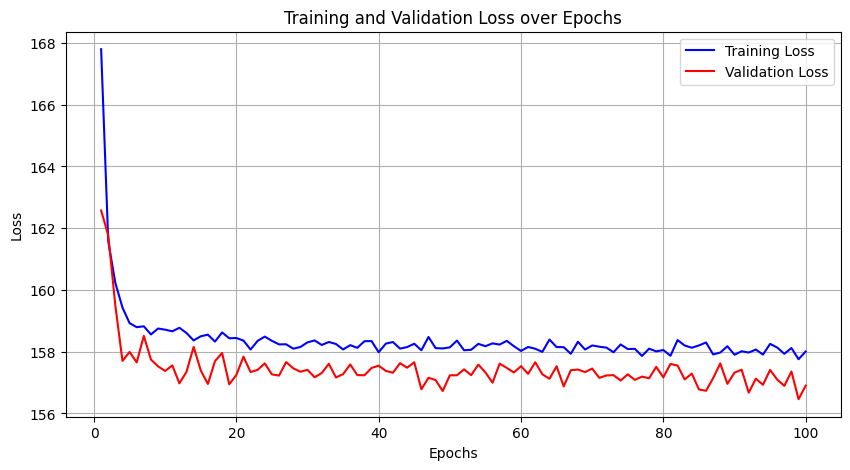

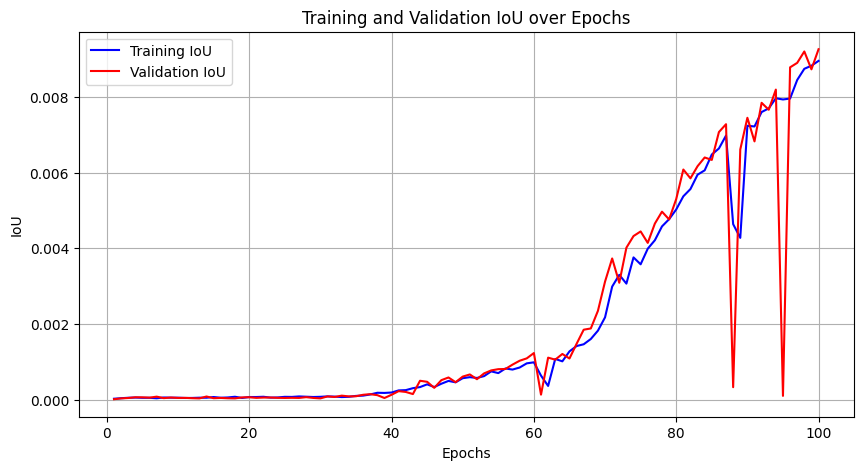

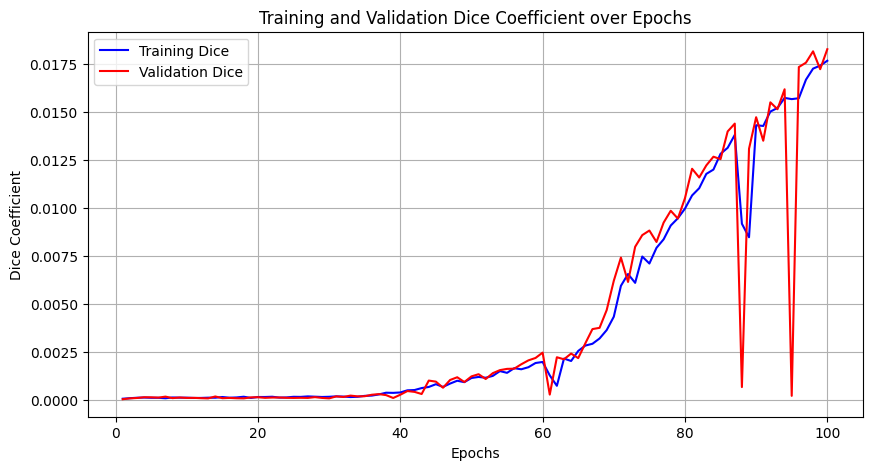

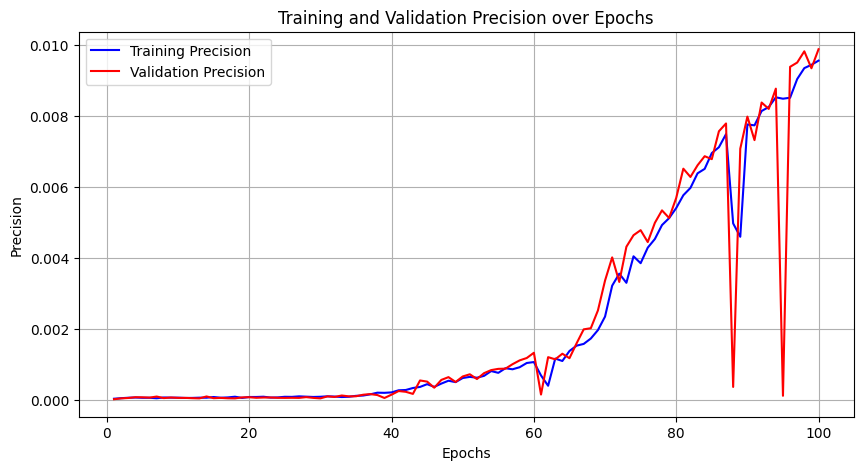

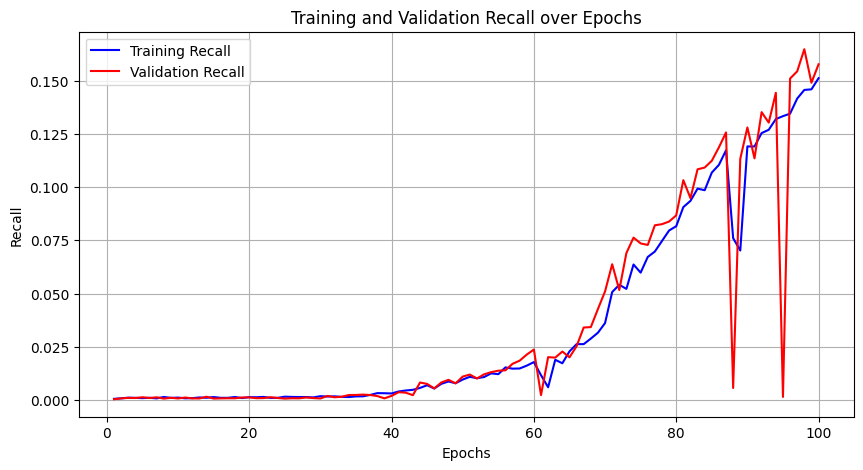

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import sys

# Define hyperparameters
LEARNING_RATE = 1e-5
BATCH_SIZE = 4
EPOCHS = 100
IMAGE_DIR = "C:/Users/alamsal/DL Project/clipped_rasters_train_data"
MASK_DIR = "C:/Users/alamsal/DL Project/clipped_ground_truth_train_data"
MODEL_SAVE_PATH = "C:/Users/alamsal/DL Project/unet_model_cel/unet_model_cel.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset and split into training and validation sets
train_dataset = DEMDataset(IMAGE_DIR, MASK_DIR)
train_dataset, val_dataset = random_split(
    train_dataset,
    [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))],
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = UNet(in_channels=1, out_channels=1).to(device)

class WeightedCEL(nn.Module):
    def __init__(self, weight_pos=500, weight_neg=1.0):
        super(WeightedCEL, self).__init__()
        self.weight_pos = weight_pos
        self.weight_neg = weight_neg

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        loss_pos = -self.weight_pos * (targets * F.logsigmoid(inputs))
        loss_neg = -self.weight_neg * ((1 - targets) * F.logsigmoid(-inputs))

        loss = (loss_pos + loss_neg).mean()
        return loss

weight_pos = 500  # Weight for positive class
weight_neg = 1  # Weight for negative class
criterion = WeightedCEL(weight_pos=weight_pos, weight_neg=weight_neg)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

no_improve_epochs = 0
best_val_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    iou_sum, dice_sum = 0.0, 0.0
    precision_sum, recall_sum = 0.0, 0.0

    for imgs, masks in tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{EPOCHS}'):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks) * 100
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        outputs_sigmoid = torch.sigmoid(outputs) 

        outputs_flat = outputs_sigmoid.view(-1) # Flatten outputs to compute the 99.9th percentile
        
        threshold_value = torch.quantile(outputs_flat, 0.999) # Compute the 99.9 percentile threshold

        preds = (outputs_sigmoid > threshold_value).float() # Assigning 1 to pixels exceeding the threshold and 0 to the rest

        masks_binary = (masks == 1).float() # Modify ground truth masks: assign 1 to pixels with value 1

        # Flatten tensors for metric calculations
        preds_flat = preds.view(-1).byte()
        masks_flat = masks_binary.view(-1).byte()

        TP = (preds_flat & masks_flat).sum().item()
        FP = ((preds_flat == 1) & (masks_flat == 0)).sum().item()
        FN = ((preds_flat == 0) & (masks_flat == 1)).sum().item()
        TN = ((preds_flat == 0) & (masks_flat == 0)).sum().item()

        iou = TP / (TP + FP + FN + 1e-6)
        dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
        precision = TP / (TP + FP + 1e-6)
        recall = TP / (TP + FN + 1e-6)

        iou_sum += iou
        dice_sum += dice
        precision_sum += precision
        recall_sum += recall

    train_loss_epoch = running_loss / len(train_loader)
    mean_iou = iou_sum / len(train_loader)
    mean_dice = dice_sum / len(train_loader)
    mean_precision = precision_sum / len(train_loader)
    mean_recall = recall_sum / len(train_loader)

    train_losses.append(train_loss_epoch)
    train_ious.append(mean_iou)
    train_dices.append(mean_dice)
    train_precisions.append(mean_precision)
    train_recalls.append(mean_recall)

    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {train_loss_epoch:.6f}, "
        f"IoU: {mean_iou:.6f}, Dice: {mean_dice:.6f}, "
        f"Precision: {mean_precision:.6f}, Recall: {mean_recall:.6f}"
    )

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    iou_sum, dice_sum = 0.0, 0.0
    precision_sum, recall_sum = 0.0, 0.0

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc='Validation'):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks) * 100
            val_loss += loss.item()

            outputs_sigmoid = torch.sigmoid(outputs)  # Apply sigmoid activation to outputs

            outputs_flat = outputs_sigmoid.view(-1)  # Flatten outputs to compute percentile

            threshold_value = torch.quantile(outputs_flat, 0.999)  # Use same percentile as training

            preds = (outputs_sigmoid > threshold_value).float()  # Threshold predictions
            masks_binary = (masks == 1).float()  # Binary masks

            preds_flat = preds.view(-1).byte()
            masks_flat = masks_binary.view(-1).byte()

            TP = (preds_flat & masks_flat).sum().item()
            FP = ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            FN = ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            TN = ((preds_flat == 0) & (masks_flat == 0)).sum().item()

            iou = TP / (TP + FP + FN + 1e-6)
            dice = 2 * TP / (2 * TP + FP + FN + 1e-6)
            precision = TP / (TP + FP + 1e-6)
            recall = TP / (TP + FN + 1e-6)

            iou_sum += iou
            dice_sum += dice
            precision_sum += precision
            recall_sum += recall

    val_loss /= len(val_loader)
    mean_iou = iou_sum / len(val_loader)
    mean_dice = dice_sum / len(val_loader)
    mean_precision = precision_sum / len(val_loader)
    mean_recall = recall_sum / len(val_loader)

    val_losses.append(val_loss)
    val_ious.append(mean_iou)
    val_dices.append(mean_dice)
    val_precisions.append(mean_precision)
    val_recalls.append(mean_recall)

    print(
        f"Epoch {epoch+1}/{EPOCHS}, "
        f"Val Loss: {val_loss:.6f}, "
        f"Val IoU: {mean_iou:.6f}, Val Dice: {mean_dice:.6f}, "
        f"Val Precision: {mean_precision:.6f}, Val Recall: {mean_recall:.6f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    else:
        no_improve_epochs += 1

epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_losses, 'b-', label='Training Loss')
plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_ious, 'b-', label='Training IoU')
plt.plot(epochs_range, val_ious, 'r-', label='Validation IoU')
plt.title('Training and Validation IoU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_dices, 'b-', label='Training Dice')
plt.plot(epochs_range, val_dices, 'r-', label='Validation Dice')
plt.title('Training and Validation Dice Coefficient over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_precisions, 'b-', label='Training Precision')
plt.plot(epochs_range, val_precisions, 'r-', label='Validation Precision')
plt.title('Training and Validation Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_recalls, 'b-', label='Training Recall')
plt.plot(epochs_range, val_recalls, 'r-', label='Validation Recall')
plt.title('Training and Validation Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()


## Inference and Visualization

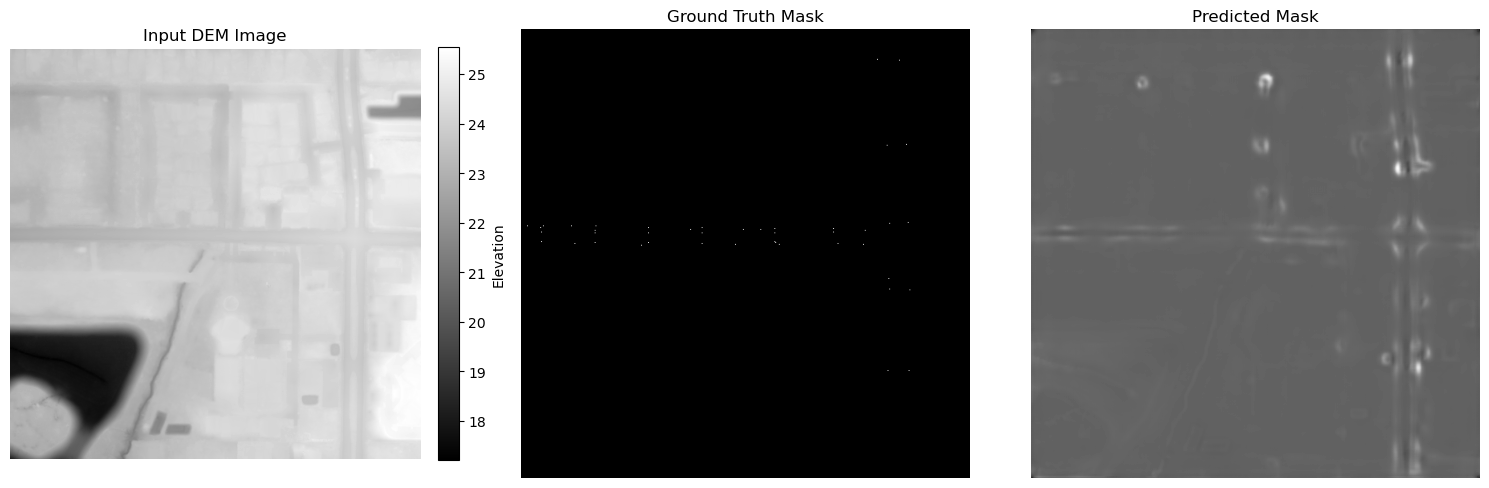

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import rasterio
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from PIL import Image 

class DEMDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        valid_extensions = ['.tif', '.tiff']  
        self.images = sorted([os.path.join(self.image_dir, f) for f in os.listdir(self.image_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])
        self.masks = sorted([os.path.join(self.mask_dir, f) for f in os.listdir(self.mask_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):        
        with rasterio.open(self.images[index]) as img_file:   
            img = Image.fromarray(img_file.read(1))
        with rasterio.open(self.masks[index]) as mask_file:
            mask = Image.fromarray(mask_file.read(1))

        seed = np.random.randint(2147483647)            
        if self.transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            img = self.transform(img)            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transform(mask)
                  
        return img, mask

    def __len__(self):
        return len(self.images)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))

        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        return self.out_conv(dec1)


def predict_and_visualize(image_path, image_mask, model, device):
    
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    with rasterio.open(image_path) as img_file:
        img = img_file.read(1)
        meta = img_file.meta.copy()

    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(device)
    
    with rasterio.open(image_mask) as imgm_file:
        imgm = imgm_file.read(1)
    imgm = Image.fromarray(imgm)
    imgm = transform(imgm).squeeze().numpy()      
    
    with torch.no_grad():
        pred = model(img)
    pred = torch.sigmoid(pred).cpu().squeeze().numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input DEM Image")
    im = plt.imshow(img.cpu().squeeze(), cmap='gray')
    cbar = plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)
    cbar.set_label('Elevation')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(imgm, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    output_tif_path = "Predicted_Mask_dl3.tif"
    meta.update({"driver": "GTiff", "height": pred.shape[0], "width": pred.shape[1], "count": 1, "dtype": "float32"})
    with rasterio.open(output_tif_path, "w", **meta) as dest:
        dest.write(pred.astype("float32"), 1)

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "C:/Users/alamsal/DL Project/unet_model_cel/unet_model_cel.pth"


model = UNet(in_channels=1, out_channels=1).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device,weights_only=False))

TEST_IMAGE_PATH = "C:/Users/alamsal/DL Project/clipped_rasters_train_data/A_009_063.tif"
TEST_IMAGE_MASK = "C:/Users/alamsal/DL Project/clipped_ground_truth_train_data/A_009_063.tif"
predict_and_visualize(TEST_IMAGE_PATH, TEST_IMAGE_MASK, model, device)


## Post Processing

Confusion Matrix:
[[235914  26187]
 [    15     28]]
False positive 26187
False negative 15
True positive 28
True negative 235914
Accuracy: 0.9000
IoU: 0.0011
Dice Coefficient: 0.0021
Recall: 0.6512


C:\Users\alamsal\AppData\Local\Temp\ipykernel_22996\1257283843.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_locatio

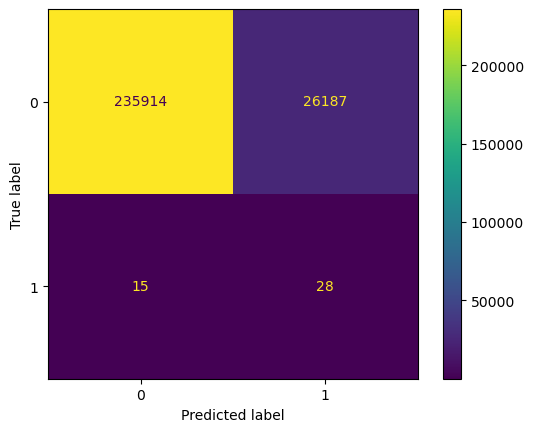

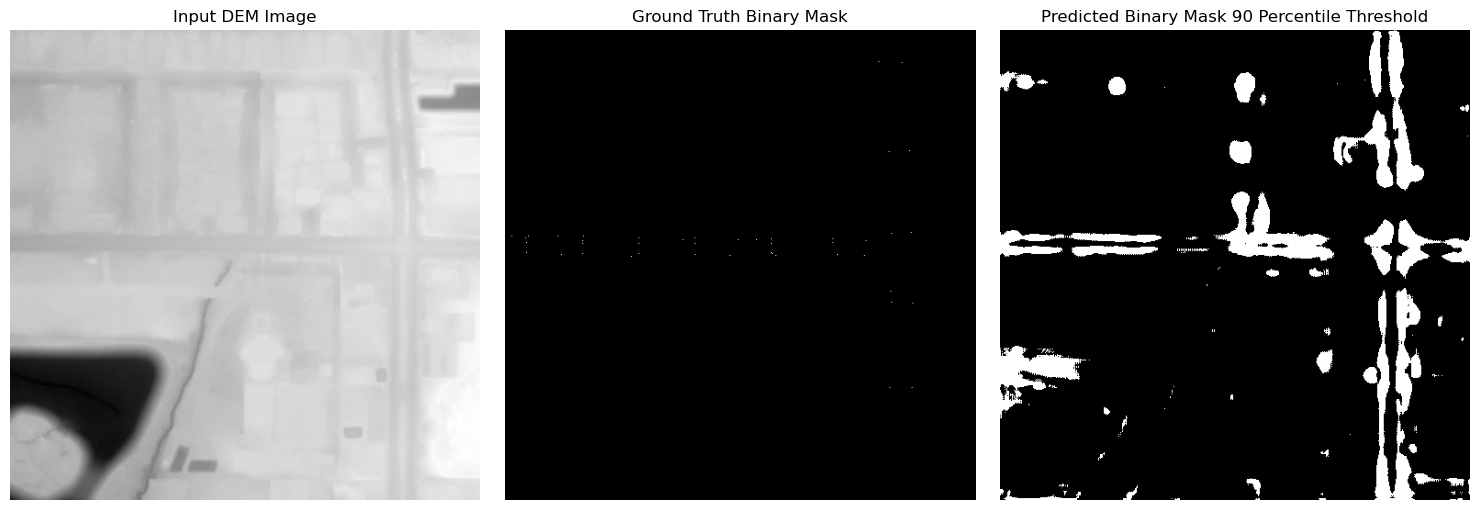

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import rasterio
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from PIL import Image  

class DEMDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        valid_extensions = ['.tif', '.tiff']  
        self.images = sorted([os.path.join(self.image_dir, f) for f in os.listdir(self.image_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])
        self.masks = sorted([os.path.join(self.mask_dir, f) for f in os.listdir(self.mask_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):        
        with rasterio.open(self.images[index]) as img_file:   
            img = Image.fromarray(img_file.read(1))
        with rasterio.open(self.masks[index]) as mask_file:
            mask = Image.fromarray(mask_file.read(1))

        seed = np.random.randint(2147483647)            
        if self.transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            img = self.transform(img)            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transform(mask)
                  
        return img, mask

    def __len__(self):
        return len(self.images)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))

        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        return self.out_conv(dec1)


def predict_and_visualize(image_path, image_mask, model, device):
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    
    with rasterio.open(image_path) as img_file:
        img = img_file.read(1)
        meta = img_file.meta.copy()

    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(device)
 
    with rasterio.open(image_mask) as imgm_file:
        imgm = imgm_file.read(1)
    imgm = Image.fromarray(imgm)
    imgm = transform(imgm).squeeze().numpy() 

    with torch.no_grad():
        pred = model(img)
    pred = torch.sigmoid(pred).cpu().squeeze().numpy()    
    
    binary_gt = np.where(imgm ==1, 1, 0)
    
    threshold_pred = np.percentile(pred, 90)
    binary_pred = np.where(pred >= threshold_pred, 1, 0)

    y_true = binary_gt.flatten()
    y_pred = binary_pred.flatten()

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    tn, fp, fn, tp = cm.ravel()

    print(f"False positive {fp}")
    print(f"False negative {fn}")
    print(f"True positive {tp}")
    print(f"True negative {tn}")

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    iou = tp / (tp + fp + fn)
    dice = (2 * tp) / (2 * tp + fp + fn)
    recall = tp/(tp+fn)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input DEM Image")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Binary Mask")
    plt.imshow(imgm, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Binary Mask 90 Percentile Threshold")
    plt.imshow(binary_pred, cmap='gray')
    plt.axis('off')       

    plt.tight_layout()
    plt.show()

    output_tif_path = "Predicted_Mask_T.tif"
    meta.update({"driver": "GTiff", "height": pred.shape[0], "width": pred.shape[1], "count": 1, "dtype": "float32"})
    with rasterio.open(output_tif_path, "w", **meta) as dest:
        dest.write(pred.astype("float32"), 1)

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "C:/Users/alamsal/DL Project/unet_model_cel/unet_model_cel.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "C:/Users/alamsal/DL Project/unet_model_cel/unet_model_cel.pth"

model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

TEST_IMAGE_PATH = "C:/Users/alamsal/DL Project/clipped_rasters_train_data/A_009_063.tif"
TEST_IMAGE_MASK = "C:/Users/alamsal/DL Project/clipped_ground_truth_train_data/A_009_063.tif"

predict_and_visualize(TEST_IMAGE_PATH, TEST_IMAGE_MASK, model, device)

Confusion Matrix:
[[249005  13096]
 [    31     12]]
False positive 13096
False negative 31
True positive 12
True negative 249005
Accuracy: 0.9499
IoU: 0.0009
Dice Coefficient: 0.0018
Recall: 0.2791


C:\Users\alamsal\AppData\Local\Temp\ipykernel_22996\3428382648.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_locatio

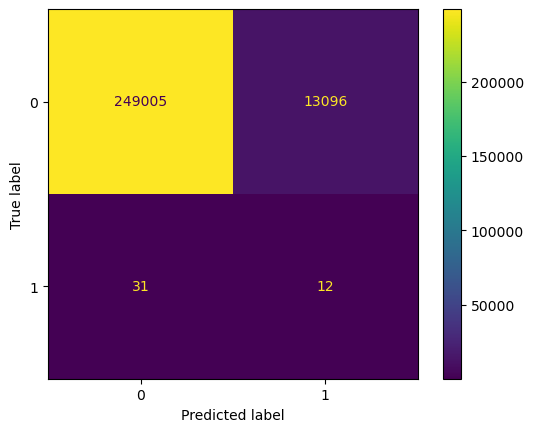

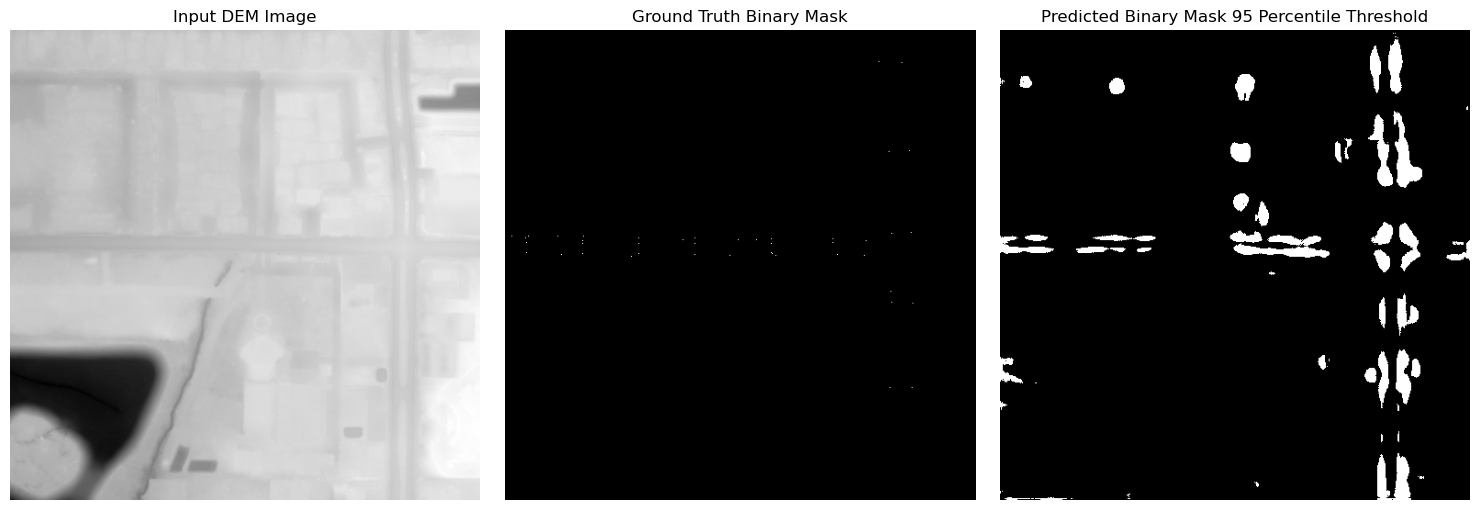

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import rasterio
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from PIL import Image  

class DEMDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        valid_extensions = ['.tif', '.tiff']  
        self.images = sorted([os.path.join(self.image_dir, f) for f in os.listdir(self.image_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])
        self.masks = sorted([os.path.join(self.mask_dir, f) for f in os.listdir(self.mask_dir) if os.path.splitext(f)[-1].lower() in valid_extensions])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.RandomRotation(90),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):        
        with rasterio.open(self.images[index]) as img_file:   
            img = Image.fromarray(img_file.read(1))
        with rasterio.open(self.masks[index]) as mask_file:
            mask = Image.fromarray(mask_file.read(1))

        seed = np.random.randint(2147483647)            
        if self.transform is not None:
            random.seed(seed)
            torch.manual_seed(seed)
            img = self.transform(img)            
            random.seed(seed)
            torch.manual_seed(seed)
            mask = self.transform(mask)
                  
        return img, mask

    def __len__(self):
        return len(self.images)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))

        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))

        dec4 = self.dec4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        return self.out_conv(dec1)


def predict_and_visualize(image_path, image_mask, model, device):
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    
    with rasterio.open(image_path) as img_file:
        img = img_file.read(1)
        meta = img_file.meta.copy()

    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(device)
 
    with rasterio.open(image_mask) as imgm_file:
        imgm = imgm_file.read(1)
    imgm = Image.fromarray(imgm)
    imgm = transform(imgm).squeeze().numpy() 

    with torch.no_grad():
        pred = model(img)
    pred = torch.sigmoid(pred).cpu().squeeze().numpy()    
    
    binary_gt = np.where(imgm ==1, 1, 0)
    
    threshold_pred = np.percentile(pred, 95)
    binary_pred = np.where(pred >= threshold_pred, 1, 0)

    y_true = binary_gt.flatten()
    y_pred = binary_pred.flatten()

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    tn, fp, fn, tp = cm.ravel()

    print(f"False positive {fp}")
    print(f"False negative {fn}")
    print(f"True positive {tp}")
    print(f"True negative {tn}")

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    iou = tp / (tp + fp + fn)
    dice = (2 * tp) / (2 * tp + fp + fn)
    recall = tp/(tp+fn)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou:.4f}")
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"Recall: {recall:.4f}")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input DEM Image")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Binary Mask")
    plt.imshow(imgm, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Binary Mask 95 Percentile Threshold")
    plt.imshow(binary_pred, cmap='gray')
    plt.axis('off')       

    plt.tight_layout()
    plt.show()

    output_tif_path = "Predicted_Mask_T.tif"
    meta.update({"driver": "GTiff", "height": pred.shape[0], "width": pred.shape[1], "count": 1, "dtype": "float32"})
    with rasterio.open(output_tif_path, "w", **meta) as dest:
        dest.write(pred.astype("float32"), 1)

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "C:/Users/alamsal/DL Project/unet_model_cel/unet_model_cel.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "C:/Users/alamsal/DL Project/unet_model_cel/unet_model_cel.pth"

model = UNet(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

TEST_IMAGE_PATH = "C:/Users/alamsal/DL Project/clipped_rasters_train_data/A_009_063.tif"
TEST_IMAGE_MASK = "C:/Users/alamsal/DL Project/clipped_ground_truth_train_data/A_009_063.tif"

predict_and_visualize(TEST_IMAGE_PATH, TEST_IMAGE_MASK, model, device)